<a href="https://colab.research.google.com/github/wira29/2141720184_machine-learning_2023/blob/main/minggu-10/praktikum1_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup
###Impor matplotlib dan buat fungsi pembantu untuk memplot grafik:

In [ ]:

import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Setup input pipeline
### Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif. Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Excellent view of a mature woman, that is going to lose everything (even the pruner has a mortgage). The way she gets involved into this special "business", the innocence, and the true love that exists between the people of a little town, it\'s mixed perfectly to give us as result a fresh, light and funny comedy. I couldn\'t stop laughing with a very funny scene of two old ladies in a drugstore.<br /><br />I love European films, and with movies like this one, my opinion grows stronger. A movie that I also recommend with my eyes closed, in this same genre, is Waking Ned Devine.<br /><br />Saving Grace, a comedy that many friends enjoyed as much as myself. You will love it.'
 b'Or released on DVD or screened on a cable channel like Amer. Life TV network. I have been watching another favorite, "Voyage to the Bottom of the Sea", as well as "Lost in Space" and Land of Giants". They\'ve been showing them forever but aren\'t receptive to suggestions for other shows. My father and I

# Buat Teks Encoder

Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

Metode .adapt mengatur kosakata lapisan. 20 token pertama dapat dilihat dengan kode berikut. Setelah padding dan token yang tidak diketahui, mereka diurutkan berdasarkan frekuensi

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap)

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[312, 675,   5, ...,   0,   0,   0],
       [ 42, 627,  21, ...,   0,   0,   0],
       [  2,   1,   5, ...,   0,   0,   0]])

Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:

-Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".

-Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Excellent view of a mature woman, that is going to lose everything (even the pruner has a mortgage). The way she gets involved into this special "business", the innocence, and the true love that exists between the people of a little town, it\'s mixed perfectly to give us as result a fresh, light and funny comedy. I couldn\'t stop laughing with a very funny scene of two old ladies in a drugstore.<br /><br />I love European films, and with movies like this one, my opinion grows stronger. A movie that I also recommend with my eyes closed, in this same genre, is Waking Ned Devine.<br /><br />Saving Grace, a comedy that many friends enjoyed as much as myself. You will love it.'
Round-trip:  excellent view of a [UNK] woman that is going to [UNK] everything even the [UNK] has a [UNK] the way she gets involved into this special business the [UNK] and the true love that [UNK] between the people of a little town its [UNK] perfectly to give us as result a [UNK] light and funny comedy

## Buat Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


Untuk memastikan bahwa ini berfungsi seperti yang diharapkan, evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan (padding) untuk disamarkan

In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


1/1 [==============================] - 8s 8s/step
[-0.01913259]


Sekarang, evaluasi lagi dalam batch dengan kalimat yang lebih panjang. Hasilnya harus sama

In [ ]:

# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 66ms/step
[-0.01913259]


Compile model keras untuk mengonfigurasi proses pelatihan

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train Model

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset, validation_steps=30)

Epoch 1/10
391/391 [==============================] - 59s 124ms/step - loss: 0.6508 - accuracy: 0.5642 - val_loss: 0.5548 - val_accuracy: 0.6823
Epoch 2/10
391/391 [==============================] - 31s 80ms/step - loss: 0.4655 - accuracy: 0.7709 - val_loss: 0.4082 - val_accuracy: 0.8203
Epoch 3/10
391/391 [==============================] - 32s 82ms/step - loss: 0.3659 - accuracy: 0.8388 - val_loss: 0.3608 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 30s 77ms/step - loss: 0.3344 - accuracy: 0.8561 - val_loss: 0.3387 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3157 - accuracy: 0.8627 - val_loss: 0.3280 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 27s 70ms/step - loss: 0.3085 - accuracy: 0.8673 - val_loss: 0.3285 - val_accuracy: 0.8583
Epoch 7/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3045 - accuracy: 0.8711 - val_loss: 0.3331 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 13s 34ms/step - loss: 0.3301 - accuracy: 0.8422
Test Loss: 0.3301110863685608
Test Accuracy: 0.842199981212616


(0.0, 0.6683736458420754)

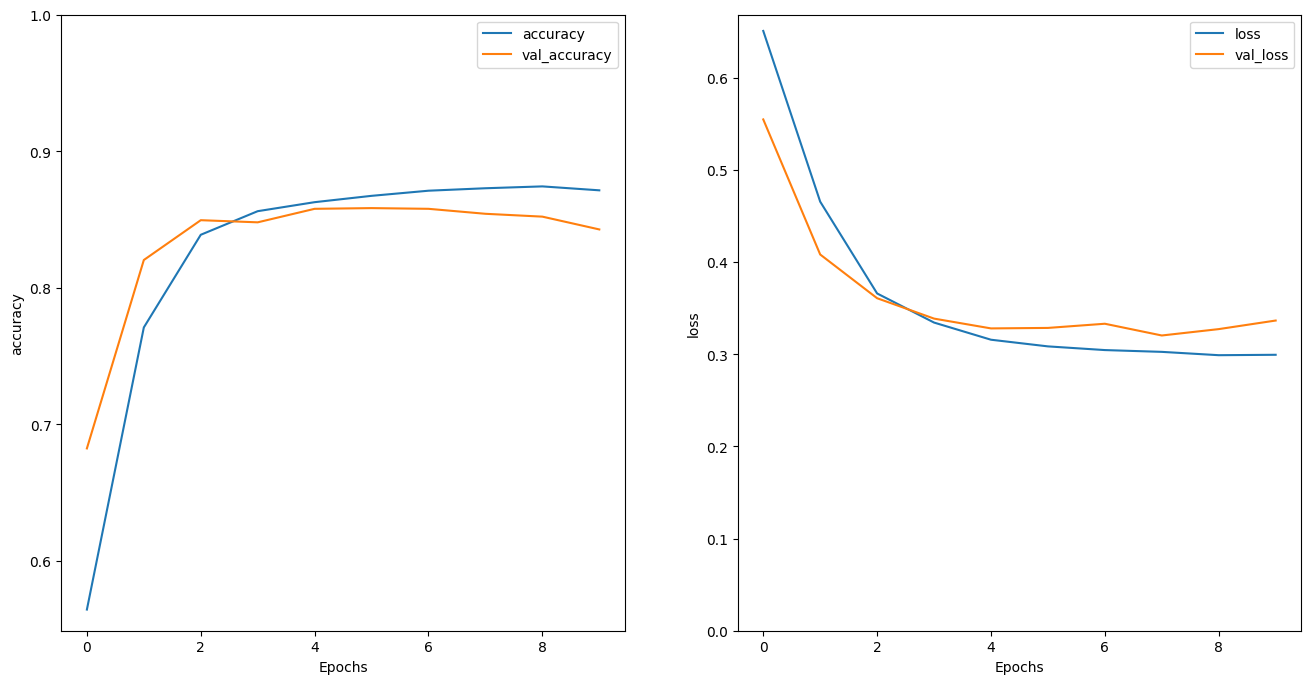

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Jalankan prediksi pada kalimat baru:

Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif

In [ ]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])


1/1 [==============================] - 3s 3s/step
[0.61191916]


### Stack Two or More LSTM Layers
Hal yang menarik dari penggunaan RNN dengan return_sequences=True adalah outputnya masih memiliki 3 axis, sama seperti inputnya, sehingga bisa diteruskan ke layer RNN lain, seperti ini

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 84s 162ms/step - loss: 0.6194 - accuracy: 0.6081 - val_loss: 0.4463 - val_accuracy: 0.7984
Epoch 2/10
391/391 [==============================] - 50s 128ms/step - loss: 0.3779 - accuracy: 0.8364 - val_loss: 0.3770 - val_accuracy: 0.8094
Epoch 3/10
391/391 [==============================] - 52s 131ms/step - loss: 0.3331 - accuracy: 0.8584 - val_loss: 0.3292 - val_accuracy: 0.8495
Epoch 4/10
391/391 [==============================] - 51s 129ms/step - loss: 0.3166 - accuracy: 0.8657 - val_loss: 0.3300 - val_accuracy: 0.8552
Epoch 5/10
391/391 [==============================] - 53s 134ms/step - loss: 0.3082 - accuracy: 0.8692 - val_loss: 0.3168 - val_accuracy: 0.8547
Epoch 6/10
391/391 [==============================] - 54s 137ms/step - loss: 0.3033 - accuracy: 0.8701 - val_loss: 0.3441 - val_accuracy: 0.8635
Epoch 7/10
391/391 [==============================] - 51s 131ms/step - loss: 0.2978 - accuracy: 0.8732 - val_loss: 0.3246 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 55ms/step - loss: 0.3327 - accuracy: 0.8596
Test Loss: 0.3326956629753113
Test Accuracy: 0.8596000075340271


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 8s 8s/step
[[-1.5699613]]


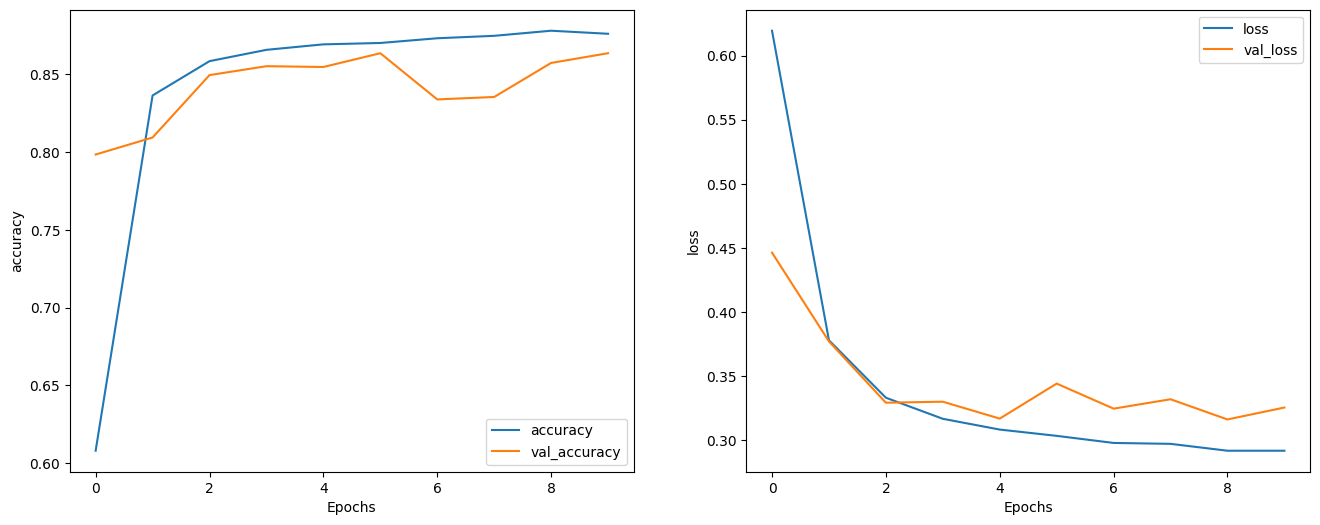

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')